In [11]:
from quasinet.qnet import load_qnet, save_qnet
from quasinet.qnet import qdistance
from quasinet.qsampling import qsample
from quasinet.qnet import membership_degree
import pandas as pd
import numpy as np
from tqdm import tqdm
import pylab as plt
from jupyterthemes import jtplot
jtplot.style()


def dissonance(pos,seq,model):
    if seq[pos]=='':
        return np.nan
    D=model.predict_distributions(seq) 
    return 1-D[pos].get(str(seq[pos]),0)
def dissonance_distr(seq,model):
    return np.array([dissonance(pos,seq,model) for pos in range(len(seq))])

def dissonance_distr_median(seq,model):
    a=dissonance_distr(seq,model)
    return np.median(a[~np.isnan(a)])

# create a naive posstr
def sample_from_pmf(pmf, L):
    """
    Draw L samples from the given PMF.

    :param pmf: A dictionary representing the PMF where keys are outcomes and values are probabilities.
    :param L: The number of samples to draw.
    :return: A list of L samples.
    """
    # Extract the outcomes and their corresponding probabilities
    outcomes = list(pmf.keys())
    probabilities = list(pmf.values())

    # Draw L samples from the outcomes based on the specified probabilities
    samples = np.random.choice(outcomes, size=L, p=probabilities)
    return samples   


In [6]:
pathdata='/home/ishanu/ZED/Research/truthnet/notebooks/data/ptsd/PTSD_cognet_test.csv'
df=pd.read_csv(pathdata,index_col=0)
model_neg=load_qnet('ptsd_neg.pkl.gz',gz=True)
#model_pos=load_qnet('ptsd_pos.pkl.gz',gz=True)
INDEX=model_neg.shap_index
featurenames=df.drop('PTSDDx',axis=1).columns

In [90]:
M=20
training_index=np.random.choice(df.index.values, 100, replace=False)
df_training=df.loc[training_index,:]
df_test = df.loc[[x for x in df.index.values if x not in training_index],:]
df_training_pos=df_training[df_training.PTSDDx==1]
df_training_neg=df_training[df_training.PTSDDx==0]
Xpos_training=df_training_pos.drop('PTSDDx',axis=1)[INDEX[:M]].values.astype(str)
Xneg_training=df_training_neg.drop('PTSDDx',axis=1)[INDEX[:M]].values.astype(str)


In [91]:
from quasinet.qnet import Qnet
modelneg=Qnet(feature_names=INDEX[:M],alpha=.1)
modelneg.fit(Xneg_training)
save_qnet(modelneg,'ptsd_neg_20.pkl.gz')
modelpos=Qnet(feature_names=INDEX[:M],alpha=.1)
modelpos.fit(Xpos_training)
save_qnet(modelpos,'ptsd_pos_20.pkl.gz')


In [92]:
! ls -lhtr *gz | tail -n 5

-rw-r--r-- 1 ishanu ishanu 189K Dec 27 17:08 ptsd_pos_40.pkl.gz
-rw-r--r-- 1 ishanu ishanu 194K Dec 27 17:09 ptsd_neg_30.pkl.gz
-rw-r--r-- 1 ishanu ishanu 135K Dec 27 17:09 ptsd_pos_30.pkl.gz
-rw-r--r-- 1 ishanu ishanu 135K Dec 27 17:18 ptsd_neg_20.pkl.gz
-rw-r--r-- 1 ishanu ishanu  76K Dec 27 17:18 ptsd_pos_20.pkl.gz


In [93]:
xx3=np.array(['3']*M)
xx3=pd.concat([pd.DataFrame(columns=INDEX[:M]),pd.DataFrame(xx3.reshape(1,-1),columns=INDEX[:M])]).fillna('').values[0].astype(str)

In [94]:
membership_degree(xx3,modelpos)

-18.65655044148572

In [95]:
membership_degree(xx3,modelneg)

-27.202113395828206

In [96]:
NULLSTR=np.array(['']*M)
NULLSTR=pd.concat([pd.DataFrame(columns=INDEX[:M]),pd.DataFrame(NULLSTR.reshape(1,-1),columns=INDEX[:M])]).fillna('').values[0].astype(str)
aa=[membership_degree(qsample(NULLSTR,modelpos,steps=1000),modelpos) for i in range(100)]

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm] [0.00 sec] [RSS: 0.00234859] [loc=-22.516 scale=2.942]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> Create pdf plot for the parametric method.
[distfit] >INFO> Estimated distribution: Norm(loc:-22.515984, scale:2.942378)
[distfit] >INFO> Compute significance for 1 samples.
[distfit] >INFO> Multiple test correction method applied: [fdr_bh].


{'y': array([-18.65655044]),
 'y_proba': array([0.09481551]),
 'y_pred': array(['none'], dtype='<U4'),
 'P': array([0.09481551]),
 'y_bool': array([False]),
 'df':           y   y_proba y_pred         P
 0 -18.65655  0.094816   none  0.094816}

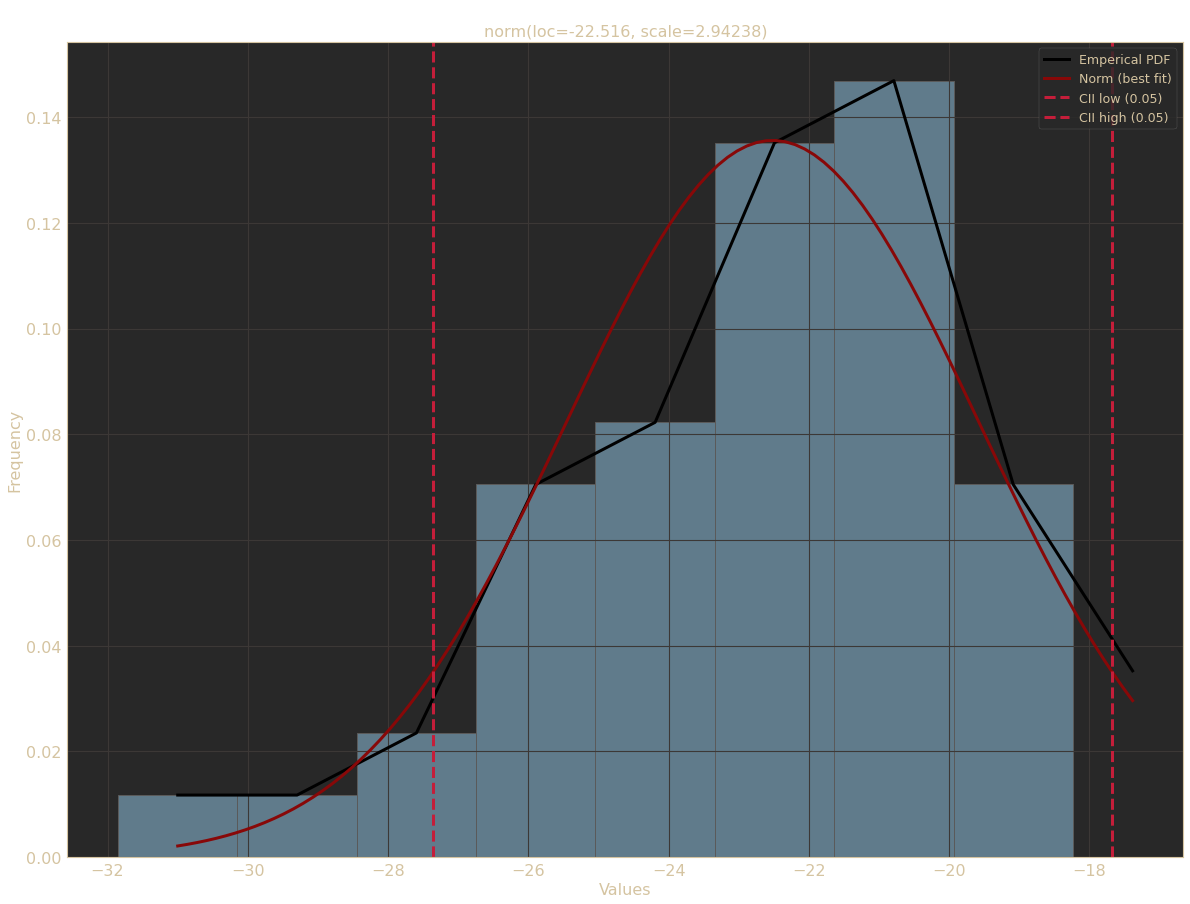

In [125]:
from distfit import distfit
dfit = distfit(distr='norm')
dfit.fit_transform(np.array(aa))
dfit.plot()
dfit.predict(membership_degree(xx3,modelpos))


In [121]:
xxx=qsample(pd.concat([pd.DataFrame(columns=INDEX[:M]),pd.DataFrame({"ptsd58": "3", "ptsd71": "3", "ptsd159": "3", "ptsd165": "3", "ptsd50": "3", "ptsd166": "3", 
              "ptsd170": "1", "ptsd131": "4", "ptsd13": "4", "ptsd93": "3", "ptsd137": "3", 
              "ptsd98": "1", "ptsd60": "4", "ptsd171": "3", "ptsd145": "3", "ptsd133": "3",
              "ptsd48": "1", "ptsd78": "4", "ptsd16": "3", "ptsd90": "3"},index=['resp'])]).fillna('')[INDEX[:M]].values[0].astype(str),modelpos,steps=50)

In [122]:
dfit.predict(membership_degree(xxx,modelpos))


[distfit] >INFO> Compute significance for 1 samples.
[distfit] >INFO> Multiple test correction method applied: [fdr_bh].


{'y': array([-22.5468922]),
 'y_proba': array([0.49580936]),
 'y_pred': array(['none'], dtype='<U4'),
 'P': array([0.49580936]),
 'y_bool': array([False]),
 'df':            y   y_proba y_pred         P
 0 -22.546892  0.495809   none  0.495809}

In [123]:
membership_degree(xxx,modelpos)

-22.546892202943642

In [124]:
xxx

array(['4', '3', '4', '4', '2', '3', '5', '3', '3', '4', '1', '3', '4',
       '2', '4', '2', '3', '3', '3', '3'], dtype='<U1')